In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [2]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [3]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [4]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 57
Matching on book_id: 2
Matching on title: 23
Total matches: 24, 42.11% of total


In [5]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Functions to Process Recommendations

In [6]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([3-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [7]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx"
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                pd.DataFrame(genres).rename(columns={0:"Genres"}).to_excel(writer, sheet_name="Genre Meanings", index=False)
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                pd.DataFrame(genres).rename(columns={0:"Genres"}).to_excel(writer, sheet_name="Genre Meanings", index=False)
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [8]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")

    return highest_rated_recs

In [9]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0]
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1]
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

## Part 1 - User:User Collaborative Filtering with KNN

### 1.1 - Generate Recommendations from Similar Readers

In [10]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_10472/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_10472/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


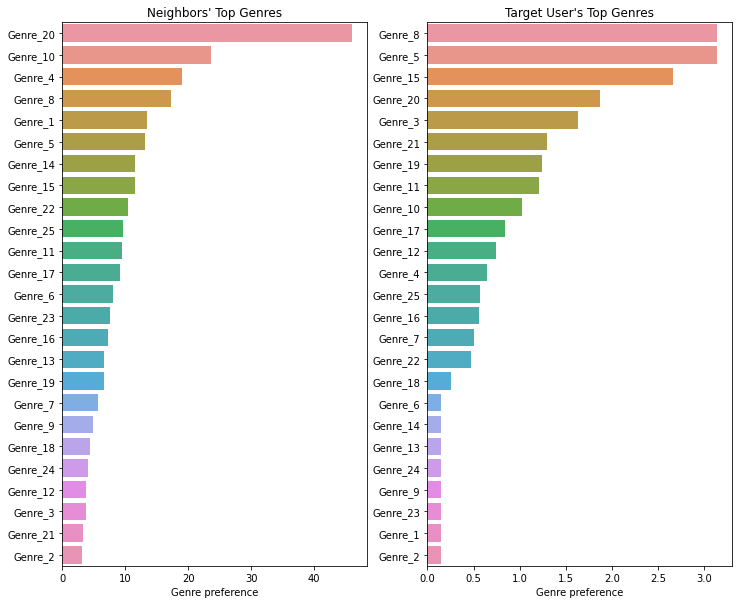

In [11]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [12]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
4,All the Ugly and Wonderful Things,4.10,35002.0,2016,4.2%,https://www.goodreads.com/book/show/26114135-a...
0,A Million Junes,4.08,3178.0,2017,2.8%,https://www.goodreads.com/book/show/30763950-a...
72,The Light We Lost,3.99,8701.0,2017,2.8%,https://www.goodreads.com/book/show/32956365-t...
9,Bad Feminist,3.91,43988.0,2014,2.8%,https://www.goodreads.com/book/show/18813642-b...
19,"Checkmate: This is War (Travis & Viola, #1) (C...",3.91,3845.0,2016,2.8%,https://www.goodreads.com/book/show/31946442-c...
77,The Mothers,3.86,22346.0,2016,2.8%,https://www.goodreads.com/book/show/28815371-t...
40,Little & Lion,3.81,1648.0,2017,2.8%,https://www.goodreads.com/book/show/25062038-l...
66,The Fever Series,4.65,4304.0,2012,1.4%,https://www.goodreads.com/book/show/15842007-t...
96,Wherever You Are My Love Will Find You,4.58,1986.0,2010,1.4%,https://www.goodreads.com/book/show/8079108-wh...
93,We Were Eight Years in Power: An American Tragedy,4.51,1534.0,2017,1.4%,https://www.goodreads.com/book/show/33916061-w...


In [13]:
# Highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15)

,title,avg_rating,ratings_count,year,url
66,The Fever Series,4.65,4304.0,2012,https://www.goodreads.com/book/show/15842007-t...
96,Wherever You Are My Love Will Find You,4.58,1986.0,2010,https://www.goodreads.com/book/show/8079108-wh...
93,We Were Eight Years in Power: An American Tragedy,4.51,1534.0,2017,https://www.goodreads.com/book/show/33916061-w...
62,"The Brightest Sunset (The Darkest Sunrise, #2)",4.46,2382.0,2017,https://www.goodreads.com/book/show/34374740-t...
86,The War that Saved My Life (The War That Saved...,4.44,21307.0,2015,https://www.goodreads.com/book/show/20912424-t...
101,Wonder (Wonder #1),4.43,255461.0,2012,https://www.goodreads.com/book/show/11387515-w...
70,The Hiding Place: The Triumphant True Story of...,4.42,177142.0,1971,https://www.goodreads.com/book/show/561909.The...
14,"Blood for Blood (Wolf By Wolf, #2)",4.33,3402.0,2016,https://www.goodreads.com/book/show/26864835-b...
73,The Magic Strings of Frankie Presto,4.30,17187.0,2015,https://www.goodreads.com/book/show/25142924-t...
55,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,https://www.goodreads.com/book/show/5544.Surel...


In [14]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, others=neighbor_user_ratings, how="KNN", 
    whose_genres="target", n_genres=5, min_score=3.9, min_ratings=400, n_recs=15
)

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
5,"Peaceful Parent, Happy Kids: How to Stop Yelli...",4.26,2276.0,https://www.goodreads.com/book/show/13542640-p...
16,Wild Things: The Art of Nurturing Boys,4.19,1241.0,https://www.goodreads.com/book/show/5893865-wi...
10,The Four Agreements: A Practical Guide to Pers...,4.12,5940.0,https://www.goodreads.com/book/show/386482.The...
2,Genome: the Autobiography of a Species in 23 C...,4.02,18173.0,https://www.goodreads.com/book/show/4591.Genome
1,Change Anything: The New Science of Personal S...,3.95,1909.0,https://www.goodreads.com/book/show/9745641-ch...
14,The Little Big Things: 163 Ways to Pursue EXCE...,3.92,816.0,https://www.goodreads.com/book/show/7440029-th...


_____

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
13,We Were Eight Years in Power: An American Tragedy,4.51,1534.0,https://www.goodreads.com/book/show/33916061-w...
8,The Radium Girls: The Dark Story of America's ...,4.26,6453.0,https://www.goodreads.com/book/show/31409135-t...
6,"Thanks, Obama: My Hopey, Changey White House Y...",4.18,551.0,https://www.goodreads.com/book/show/33640253-t...
0,A Walk Across the Sun,4.13,12306.0,https://www.goodreads.com/book/show/11469379-a...
14,You Can't Read This Book: Censorship in an Age...,4.12,453.0,https://www.goodreads.com/book/show/7954980-yo...
5,Ratification: The People Debate the Constituti...,4.08,647.0,https://www.goodreads.com/book/show/7841680-ra...
4,"Inspector of the Dead (Thomas De Quincey, #2)",4.03,1438.0,https://www.goodreads.com/book/show/22675858-i...
1,Beneath a Marble Sky,3.99,11543.0,https://www.goodreads.com/book/show/94672.Bene...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
7,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
9,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
0,Catalog of Unabashed Gratitude,4.16,1017.0,https://www.goodreads.com/book/show/23705600-c...
8,The Age of Reason,4.13,5320.0,https://www.goodreads.com/book/show/1031803.Th...
4,Men Explain Things To Me,3.92,797.0,https://www.goodreads.com/book/show/23129764-m...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
31,The Magic Strings of Frankie Presto,4.30,17187.0,https://www.goodreads.com/book/show/25142924-t...
16,North of Normal: A Memoir of My Wilderness Chi...,4.16,3428.0,https://www.goodreads.com/book/show/18635097-n...
41,Ugly Young Thing (Strangers #2),4.14,2648.0,https://www.goodreads.com/book/show/23745103-u...
28,The Disappearances,4.13,1092.0,https://www.goodreads.com/book/show/30971685-t...
22,"Sing, Unburied, Sing",4.12,4592.0,https://www.goodreads.com/book/show/32920226-s...
1,A Million Junes,4.08,3178.0,https://www.goodreads.com/book/show/30763950-a...
7,Each Little Bird that Sings,4.08,5598.0,https://www.goodreads.com/book/show/428035.Eac...
25,The Almost Sisters,4.07,4155.0,https://www.goodreads.com/book/show/32600726-t...
33,"The Notebook (The Notebook, #1)",4.07,1064723.0,https://www.goodreads.com/book/show/15931.The_...
6,Come Away with Me,4.06,2298.0,https://www.goodreads.com/book/show/23569705-c...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
2,Tales of the Peculiar (Miss Peregrine's Peculi...,4.17,10785.0,https://www.goodreads.com/book/show/29358487-t...


_____



## Part 2 - User:Item Collaborative Filtering with Matrix Factorization

#### 2.1 - Perform Matrix Factorization on User Rating Matrix

In [15]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(2000, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_10472/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_10472/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [16]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [17]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [18]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

In [19]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)

# Write to excel
path = wd + "/data/book_recs.xlsx"
if os.path.isfile(path):
    with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
else:
    with pd.ExcelWriter(path) as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
writer.close

top_preds.query("avg_rating > 3.9").head(20)    

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
11,0.061169,AM/PM,3.95,797.0,2009,11.0,https://www.goodreads.com/book/show/6123353-am-pm
18,0.050672,Bad Feminist,3.91,43988.0,2014,16.0,https://www.goodreads.com/book/show/18813642-b...
22,0.041921,The Shadow of the Wind (The Cemetery of Forgot...,4.25,691.0,2005,20.0,https://www.goodreads.com/book/show/7490773-th...
26,0.035234,Wonder (Wonder #1),4.43,255461.0,2012,16.0,https://www.goodreads.com/book/show/11387515-w...
34,0.027283,Crapalachia: A Biography of a Place,4.09,1455.0,2013,5.0,https://www.goodreads.com/book/show/13591921-c...
41,0.022622,Consider the Lobster and Other Essays,4.25,27237.0,2005,15.0,https://www.goodreads.com/book/show/6751.Consi...
42,0.022254,Genome: the Autobiography of a Species in 23 C...,4.02,18173.0,2006,8.0,https://www.goodreads.com/book/show/4591.Genome
43,0.021970,"Godchild, Volume 01",4.09,8531.0,2006,6.0,https://www.goodreads.com/book/show/500383.God...
44,0.021848,One of Us: The Story of Anders Breivik and the...,4.32,2569.0,2013,5.0,https://www.goodreads.com/book/show/22237163-o...
47,0.021406,Die Panne,4.12,703.0,1998,10.0,https://www.goodreads.com/book/show/300740.Die...


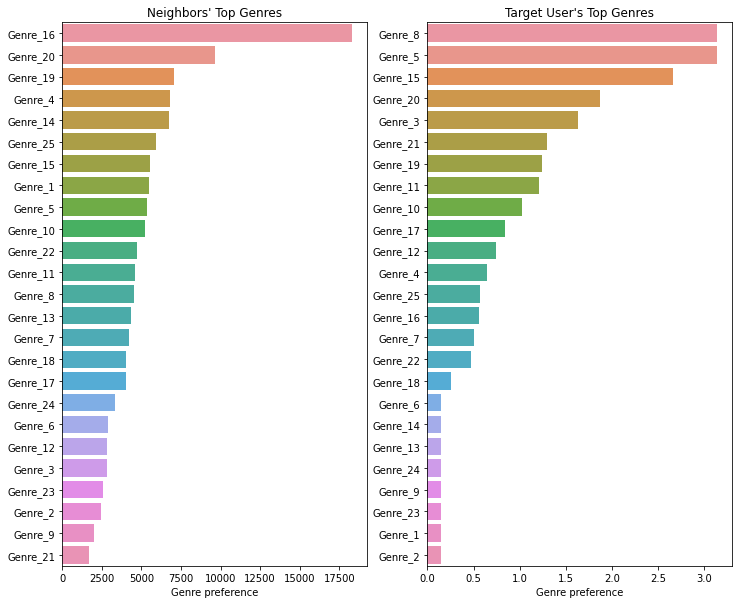

In [20]:
# Show top genres
plot_top_genres(large_neighborhood_ratings, target_user_ratings)

In [21]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(large_neighborhood_ratings, 50)

if os.path.isfile(path):
    with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
        popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
else:
    with pd.ExcelWriter(path) as writer:
        popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
writer.close

popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
13802,Wonder (Wonder #1),4.43,255461.0,2012,6.4%,https://www.goodreads.com/book/show/11387515-w...
700,All the Ugly and Wonderful Things,4.10,35002.0,2016,4.3%,https://www.goodreads.com/book/show/26114135-a...
3088,"Dumplin' (Dumplin', #1)",3.87,23974.0,2015,3.9%,https://www.goodreads.com/book/show/18304322-d...
11217,The Mothers,3.86,22346.0,2016,3.6%,https://www.goodreads.com/book/show/28815371-t...
9237,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,3.2%,https://www.goodreads.com/book/show/30253864-t...
1147,Bad Feminist,3.91,43988.0,2014,3.2%,https://www.goodreads.com/book/show/18813642-b...
1689,Born a Crime: Stories From a South African Chi...,4.45,57318.0,2016,2.9%,https://www.goodreads.com/book/show/29780253-b...
572,After I Do,4.08,8409.0,2014,2.8%,https://www.goodreads.com/book/show/18775359-a...
6529,My Brilliant Friend (The Neapolitan Novels #1),3.89,66369.0,2012,2.8%,https://www.goodreads.com/book/show/13586707-m...
6072,"March: Book One (March, #1)",4.34,21092.0,2013,2.8%,https://www.goodreads.com/book/show/17346698-m...


In [22]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(large_neighborhood_ratings, 50)

if os.path.isfile(path):
    with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
        top_rated.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
else:
    with pd.ExcelWriter(path) as writer:
        top_rated.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        
writer.close

top_rated.head(15)

,title,avg_rating,ratings_count,year,url
13828,"Words of Radiance, Part 2 (The Stormlight Arch...",4.82,1661.0,2014,https://www.goodreads.com/book/show/21100112-w...
12346,"The Way of Kings, Part 2 (The Stormlight Archi...",4.78,7803.0,2011,https://www.goodreads.com/book/show/11221285-t...
6078,Mark of the Lion Trilogy,4.76,9189.0,1998,https://www.goodreads.com/book/show/95602.Mark...
10762,The Jesus Storybook Bible: Every Story Whisper...,4.75,6081.0,2007,https://www.goodreads.com/book/show/165068.The...
5152,It's a Magical World: A Calvin and Hobbes Coll...,4.75,22578.0,1996,https://www.goodreads.com/book/show/24814.It_s...
12518,There's Treasure Everywhere: A Calvin and Hobb...,4.74,17062.0,1996,https://www.goodreads.com/book/show/70489.Ther...
3930,Fullmetal Alchemist Box Set,4.73,1171.0,2011,https://www.goodreads.com/book/show/11703437-f...
10710,The Indispensable Calvin and Hobbes,4.73,14791.0,1992,https://www.goodreads.com/book/show/24815.The_...
1043,Attack of the Deranged Mutant Killer Monster S...,4.72,9788.0,1992,https://www.goodreads.com/book/show/70487.Atta...
11651,The Revenge of the Baby-Sat,4.71,11626.0,1991,https://www.goodreads.com/book/show/121792.The...


In [23]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, large_neighborhood_ratings, preds=top_preds, how="MF", 
    whose_genres="target", n_genres=10, min_score=4.15, min_ratings=400, n_recs=20,
    write_to_excel=True
)

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
448,Syllabus: Notes from an Accidental Professor,4.35,1397.0,https://www.goodreads.com/book/show/20613619-s...
494,"Peaceful Parent, Happy Kids: How to Stop Yelli...",4.26,2276.0,https://www.goodreads.com/book/show/13542640-p...
525,"This Is Water: Some Thoughts, Delivered on a S...",4.52,13702.0,https://www.goodreads.com/book/show/5986375-th...
1269,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
1450,The Richest Man in Babylon,4.23,52607.0,https://www.goodreads.com/book/show/1052.The_R...
1466,The Miracle of Mindfulness: An Introduction to...,4.26,13653.0,https://www.goodreads.com/book/show/95747.The_...
1572,Pro: Reclaiming Abortion Rights,4.27,1184.0,https://www.goodreads.com/book/show/20518909-pro
1708,It's All Absolutely Fine,4.21,783.0,https://www.goodreads.com/book/show/29230623-i...
1712,Unwrapping the Greatest Gift: A Family Celebra...,4.38,636.0,https://www.goodreads.com/book/show/21539504-u...
1757,"2,000 to 10,000: How to Write Faster, Write Be...",4.17,2776.0,https://www.goodreads.com/book/show/16080676-2...


_____

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
44,One of Us: The Story of Anders Breivik and the...,4.32,2569.0,https://www.goodreads.com/book/show/22237163-o...
87,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
185,"March: Book Two (March, #2)",4.54,10428.0,https://www.goodreads.com/book/show/22487952-m...
282,"Thanks, Obama: My Hopey, Changey White House Y...",4.18,551.0,https://www.goodreads.com/book/show/33640253-t...
333,My Favorite Thing Is Monsters,4.26,3330.0,https://www.goodreads.com/book/show/29069374-m...
351,"Blood Meridian, or the Evening Redness in the ...",4.18,959.0,https://www.goodreads.com/book/show/10876214-b...
397,The Endurance: Shackleton's Legendary Antarcti...,4.31,15050.0,https://www.goodreads.com/book/show/537375.The...
410,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
638,Free Four: Tobias Tells the Divergent Knife-Th...,4.18,82006.0,https://www.goodreads.com/book/show/13615258-f...
645,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
41,Consider the Lobster and Other Essays,4.25,27237.0,https://www.goodreads.com/book/show/6751.Consi...
50,Catalog of Unabashed Gratitude,4.16,1017.0,https://www.goodreads.com/book/show/23705600-c...
91,Memoirs of Hadrian,4.25,8321.0,https://www.goodreads.com/book/show/12172.Memo...
93,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
96,Where I'm Calling From: New and Selected Stories,4.42,16866.0,https://www.goodreads.com/book/show/11437.Wher...
125,The Book of Frank,4.44,668.0,https://www.goodreads.com/book/show/9457848-th...
290,Nox,4.30,2034.0,https://www.goodreads.com/book/show/7428663-nox
305,Bluets,4.29,7861.0,https://www.goodreads.com/book/show/6798263-bl...
314,The Complete Short Stories of Mark Twain,4.29,5370.0,https://www.goodreads.com/book/show/2968.The_C...
331,"Clothes, Clothes, Clothes. Music, Music, Music...",4.23,4116.0,https://www.goodreads.com/book/show/19246471-c...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
22,The Shadow of the Wind (The Cemetery of Forgot...,4.25,691.0,https://www.goodreads.com/book/show/7490773-th...
108,"Far from the Tree: Parents, Children, and the ...",4.27,12131.0,https://www.goodreads.com/book/show/13547504-f...
133,Building Stories,4.28,5360.0,https://www.goodreads.com/book/show/13573235-b...
165,The Beauty of the Husband: A Fictional Essay i...,4.27,2246.0,https://www.goodreads.com/book/show/150252.The...
259,The Story of a New Name (The Neapolitan Novels...,4.36,36545.0,https://www.goodreads.com/book/show/17465515-t...
265,The Chronology of Water,4.20,4956.0,https://www.goodreads.com/book/show/9214995-th...
277,Essex County,4.30,6855.0,https://www.goodreads.com/book/show/6096829-es...
312,Maus II: A Survivor's Tale: And Here My Troubl...,4.40,93669.0,https://www.goodreads.com/book/show/15197.Maus_II
330,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
350,Taking Care,4.31,481.0,https://www.goodreads.com/book/show/297906.Tak...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
72,Tales of the Peculiar (Miss Peregrine's Peculi...,4.17,10785.0,https://www.goodreads.com/book/show/29358487-t...
311,Nimona,4.20,3222.0,https://www.goodreads.com/book/show/23131088-n...
721,"Hawkeye, Volume 2: Little Hits",4.26,16304.0,https://www.goodreads.com/book/show/17277800-h...
749,The Ones Who Walk Away from Omelas,4.34,7758.0,https://www.goodreads.com/book/show/92625.The_...
1054,Sex and Death to the Age 14,4.18,415.0,https://www.goodreads.com/book/show/38305.Sex_...
1122,The Private Eye,4.24,1847.0,https://www.goodreads.com/book/show/26247784-t...
1173,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
1319,Make Way for Ducklings,4.22,71133.0,https://www.goodreads.com/book/show/29291.Make...
1719,The Dark Tower,4.27,96576.0,https://www.goodreads.com/book/show/5091.The_D...
1763,The Stinky Cheese Man and Other Fairly Stupid ...,4.20,79914.0,https://www.goodreads.com/book/show/407429.The...


_____

Genre 21: ['mystery', 'van', 'plus', 'novella', 'ghost', 'town', 'solve', 'house', 'short', 'strange']


,title,avg_rating,ratings_count,url
563,Bad Mommy,4.16,5209.0,https://www.goodreads.com/book/show/33561990-b...
1998,The Bookshop Book,4.23,1199.0,https://www.goodreads.com/book/show/20631808-t...
2005,The Hiding Place: The Triumphant True Story of...,4.42,177142.0,https://www.goodreads.com/book/show/561909.The...
3211,Salsa Nocturna: Stories (Bone Street Rumba #2.5),4.31,407.0,https://www.goodreads.com/book/show/13568836-s...
6500,Mog the Forgetful Cat,4.30,2738.0,https://www.goodreads.com/book/show/1152265.Mo...
6760,Blow-Up and Other Stories,4.23,4958.0,https://www.goodreads.com/book/show/53410.Blow...
9169,Atlas Obscura: An Explorer's Guide to the Worl...,4.24,1777.0,https://www.goodreads.com/book/show/28110891-a...
9665,The Jesus Storybook Bible: Every Story Whisper...,4.75,6081.0,https://www.goodreads.com/book/show/165068.The...
11501,Not a Box,4.28,10753.0,https://www.goodreads.com/book/show/220596.Not...
14350,Hershel and the Hanukkah Goblins,4.26,1897.0,https://www.goodreads.com/book/show/496802.Her...


_____

Genre 19: ['friend', 'summer', 'best', 'time', 'holiday', 'school', 'family', 'going', 'day', 'year']


,title,avg_rating,ratings_count,url
945,"Ghost (Track, #1)",4.25,5937.0,https://www.goodreads.com/book/show/28954126-g...
978,The Mother Road,4.20,2052.0,https://www.goodreads.com/book/show/27467426-t...
1104,The Princess and the Pony,4.25,3596.0,https://www.goodreads.com/book/show/23604390-t...
1313,Richard Stark’s Parker: The Outfit,4.27,3425.0,https://www.goodreads.com/book/show/7961296-ri...
1490,"Grip (Grip, #1)",4.39,1859.0,https://www.goodreads.com/book/show/31207572-grip
2015,Ghetto Superstar,4.19,824.0,https://www.goodreads.com/book/show/5834024-gh...
2055,The Summer Palace (Captive Prince Short Storie...,4.41,3862.0,https://www.goodreads.com/book/show/33230173-t...
2085,In Other Lands,4.47,860.0,https://www.goodreads.com/book/show/31944679-i...
2125,Heart and Brain: An Awkward Yeti Collection,4.39,2220.0,https://www.goodreads.com/book/show/25205337-h...
2505,"Qualify (The Atlantis Grail, #1)",4.29,1452.0,https://www.goodreads.com/book/show/21845122-q...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
59,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
62,Autobiography of Red,4.32,9949.0,https://www.goodreads.com/book/show/61049.Auto...
117,The Faraway Nearby,4.19,3409.0,https://www.goodreads.com/book/show/16158561-t...
234,CivilWarLand in Bad Decline,4.22,1615.0,https://www.goodreads.com/book/show/331688.Civ...
344,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
451,The Man Suit,4.24,841.0,https://www.goodreads.com/book/show/659775.The...
499,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
526,Short Talks,4.28,450.0,https://www.goodreads.com/book/show/150256.Sho...
898,"The ‘If You Prefer a Milder Comedian, Please A...",4.35,468.0,https://www.goodreads.com/book/show/13236798-t...
1530,Writing 21st Century Fiction: High Impact Tech...,4.40,497.0,https://www.goodreads.com/book/show/14523534-w...


_____

Genre 10: ['killer', 'murder', 'case', 'police', 'dead', 'detective', 'crime', 'body', 'mystery', 'victim']


,title,avg_rating,ratings_count,url
323,"Fell, Feral City",4.18,6174.0,https://www.goodreads.com/book/show/43722.Fell...
1526,Hell's Half Acre,4.19,957.0,https://www.goodreads.com/book/show/222340.Hel...
3207,When,4.16,6136.0,https://www.goodreads.com/book/show/20338342-when
3823,"Battle Angel Alita, Volume 01: Rusty Angel",4.18,3725.0,https://www.goodreads.com/book/show/844422.Bat...
3916,A Cat Was Involved (Chet and Bernie Mystery 0.1),4.17,1155.0,https://www.goodreads.com/book/show/13546640-a...
4024,The Man Who Laughs,4.22,5449.0,https://www.goodreads.com/book/show/63038.The_...
4417,"Fables (The Deluxe Edition, #1)",4.30,7971.0,https://www.goodreads.com/book/show/6307040-fa...
4580,The Composer is Dead,4.16,2040.0,https://www.goodreads.com/book/show/3265484-th...
5738,Motel of the Mysteries,4.16,1215.0,https://www.goodreads.com/book/show/108831.Mot...
7864,"The Lewis Man (The Lewis Trilogy, #2)",4.20,8227.0,https://www.goodreads.com/book/show/12782865-t...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
134,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
272,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...
529,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
779,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
1503,Congress of the Animals,4.21,608.0,https://www.goodreads.com/book/show/10001434-c...
1798,Princeless: Raven the Pirate Princess Book 1: ...,4.34,578.0,https://www.goodreads.com/book/show/26527730-p...
1811,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
1879,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,609.0,https://www.goodreads.com/book/show/32603222-w...
1900,"First Shift: Legacy (Shift, #1)",4.21,15301.0,https://www.goodreads.com/book/show/13603717-f...
1909,"Rosie Revere, Engineer",4.54,4789.0,https://www.goodreads.com/book/show/17290220-r...


_____



In [24]:
### ATTEMPT TO DO ITEM-ITEM KNN BUT THE RESULTS ARE WEIRD

# # Instantiate KNN
# n_neighbors = 1000

# nn_model = NearestNeighbors(
#     metric="cosine",
#     algorithm="auto",
#     n_neighbors=n_neighbors,
#     n_jobs=-1
# )

# # Fit to sparse matrix
# nn_model.fit(df_reviews.T)

# # Feed in user and get neighbors and distances
# book = df_reviews.T[1815023,:].toarray()
# dists, neighbors = nn_model.kneighbors(book, return_distance=True)

# similar_books = pd.DataFrame(
#     [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"book_index", 1:"distance"}
# )

# pd.merge(similar_books, book_index.reset_index(), left_on="book_index", right_on="index")\
#     .merge(df_books, on="book_id")